# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 77667157.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

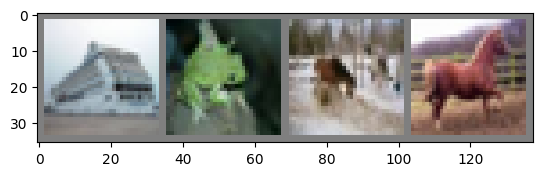

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32 x 32
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32 x 32
            nn.BatchNorm2d(num_features=32),
        )
        self.passing = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1) # 32 x 32
        self.ReLU = nn.ReLU()
        self.average_pooling = nn.AvgPool2d(8)
        self.flatten = nn.Flatten()

        self.head = nn.Linear(in_features=512, out_features=10)

        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        out = self.encoder(x) + self.passing(x)
        out = self.ReLU(out)
        out = self.average_pooling(out)
        out = self.flatten(out)
        out = self.head(out)
        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (passing): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (ReLU): ReLU()
  (average_pooling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (head): Linear(in_features=512, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        loss = 0

        with torch.no_grad():
            logits = model(data)
            loss = model.criterion(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        logits = logits.to(device)

        loss = model.criterion(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, metrics=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            if metrics is 'acc':
                scheduler.step(val_acc)
            elif metrics is 'loss':
                scheduler.step(val_loss)
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-11-51135b43a689>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if metrics is 'acc':
<ipython-input-11-51135b43a689>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif metrics is 'loss':


Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.460159491904257, train acc: 0.4802167668421046
 val loss: 1.2099045157432555, val acc: 0.5731382978723404

Epoch 1
 train loss: 1.1409817531950077, train acc: 0.6028540415563357
 val loss: 1.1301670523400003, val acc: 0.6058953901554676

Epoch 2
 train loss: 1.0320077072113916, train acc: 0.6410942805532563
 val loss: 1.0845891805405312, val acc: 0.629942376055616

Epoch 3
 train loss: 0.983766196414801, train acc: 0.6574089188244486
 val loss: 1.0925104123480776, val acc: 0.630562943346957

Epoch 4
 train loss: 0.9465592488292366, train acc: 0.672736027776868
 val loss: 0.9583679676055908, val acc: 0.6670434398854033

Epoch 5
 train loss: 0.9252570488335228, train acc: 0.6772982502114402
 val loss: 0.9544854202169053, val acc: 0.6746010638297872

Epoch 6
 train loss: 0.9008663815379797, train acc: 0.6870062353406136
 val loss: 0.9741652158980674, val acc: 0.6672429079705097

Epoch 7
 train loss: 0.881705625292588, train acc: 0.6930048642254398
 val loss: 0.96802

Посчитайте точность на тестовой выборке:

In [ ]:
total = 0
correct = 0

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

69.31 %


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

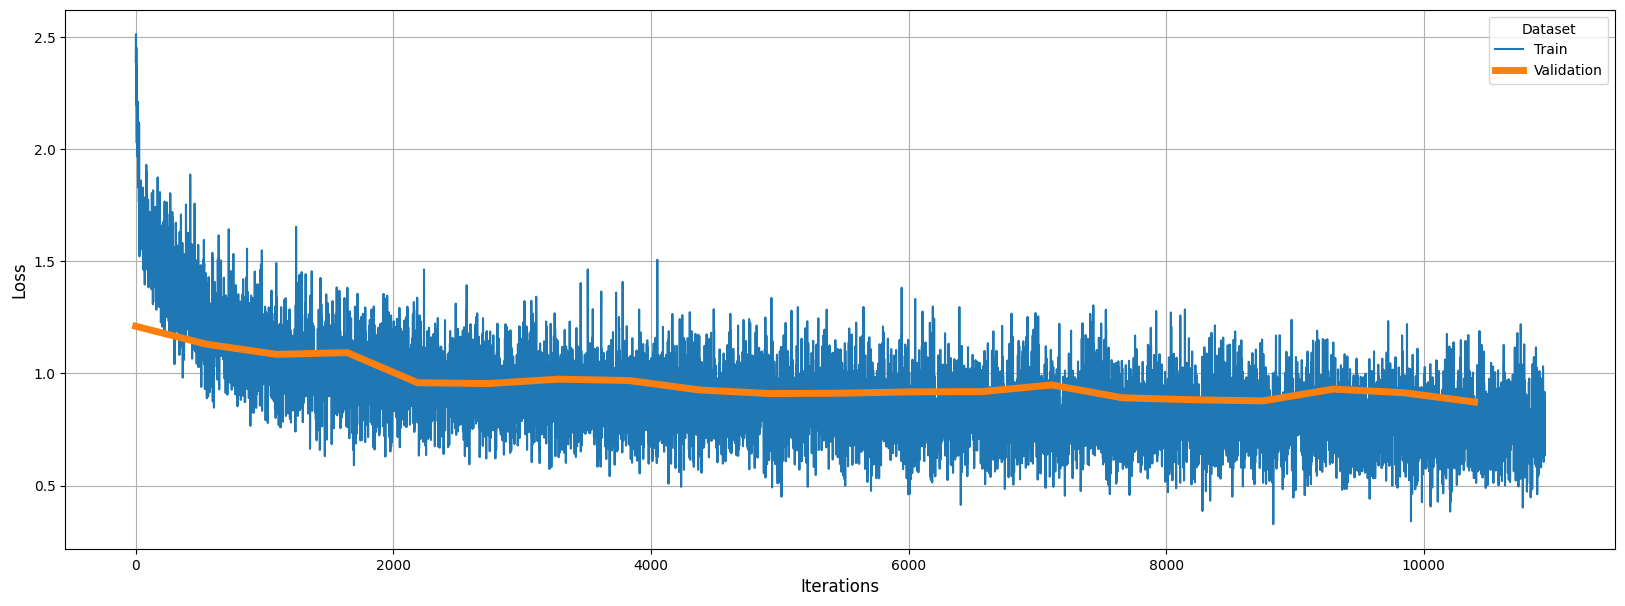

In [ ]:
plt.rcParams['figure.figsize'] = 20, 7

plt.plot(range(len(train_loss_log)), train_loss_log)
plt.plot(range(0, len(val_loss_log) * len(train_loader), len(train_loader)), val_loss_log, linewidth=5)

plt.legend(title='Dataset', labels=['Train', 'Validation'])

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.grid()
plt.show()

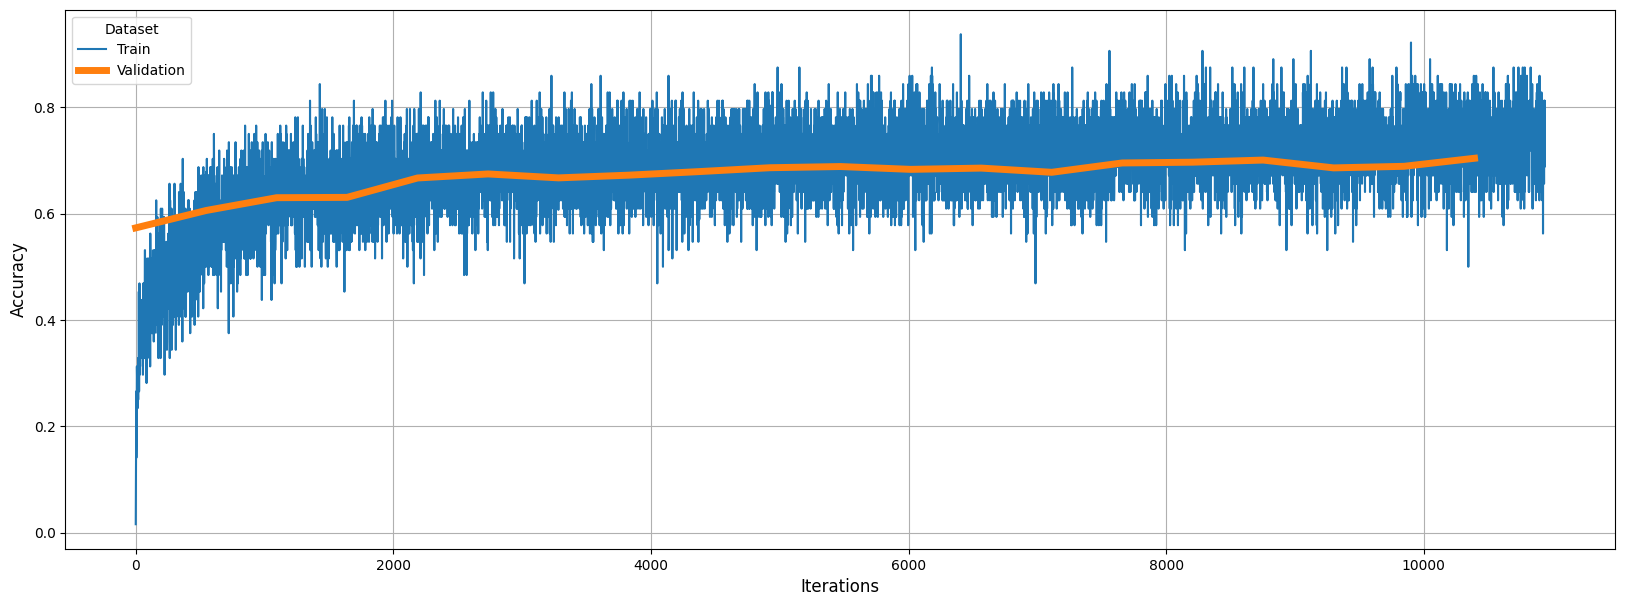

In [ ]:
plt.rcParams['figure.figsize'] = 20, 7

plt.plot(range(len(train_acc_log)), train_acc_log)
plt.plot(range(0, len(val_acc_log) * len(train_loader), len(train_loader)), val_acc_log, linewidth=5)

plt.legend(title='Dataset', labels=['Train', 'Validation'])

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4651209746897766, train acc: 0.47808664143630314
 val loss: 1.2943251467765646, val acc: 0.540004432708659

Epoch 1
 train loss: 1.1455146725914378, train acc: 0.5989243275940527
 val loss: 1.1439500352169605, val acc: 0.6049645390916378

Epoch 2
 train loss: 1.048868765560757, train acc: 0.6341162837183671
 val loss: 1.181305501308847, val acc: 0.591622340425532

Epoch 3
 train loss: 0.9911565987675892, train acc: 0.6546666884770995
 val loss: 1.0060233899887572, val acc: 0.6562943263256803

Epoch 4
 train loss: 0.9509630296958212, train acc: 0.6675290545990088
 val loss: 1.0308703790319727, val acc: 0.6417553191489361

Epoch 5
 train loss: 0.9185948439446402, train acc: 0.6803057261315298
 val loss: 0.9518516520236401, val acc: 0.6723847518575953

Epoch 6
 train loss: 0.8970818585516984, train acc: 0.6873857404021938
 val loss: 0.9225278108677966, val acc: 0.6830008866939139

Epoch 7
 train loss: 0.8809259843346842, train acc: 0.6936985831809872
 val loss: 0.89

Посчитайте точность на тестовой выборке:

In [ ]:
total = 0
correct = 0

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

71.87 %


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.001, total_iters=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 2.2027386727673046, train acc: 0.2012274745558908
 val loss: 2.077927381434339, val acc: 0.27282801422666997

Epoch 1
 train loss: 2.022466165927908, train acc: 0.29552836904142193
 val loss: 1.9524551736547593, val acc: 0.32746010638297873

Epoch 2
 train loss: 1.9241843792376614, train acc: 0.3376983220551088
 val loss: 1.8766359552424006, val acc: 0.3595523050490846

Epoch 3
 train loss: 1.856520435927773, train acc: 0.3615255288820598
 val loss: 1.814829368794218, val acc: 0.37985372340425533

Epoch 4
 train loss: 1.8064388167487637, train acc: 0.38060688171569784
 val loss: 1.7720920679417063, val acc: 0.39095744680851063

Epoch 5
 train loss: 1.7641590164609975, train acc: 0.39129831553377226
 val loss: 1.7325627118983167, val acc: 0.40636081568738247

Epoch 6
 train loss: 1.7277753575410442, train acc: 0.4031201032223606
 val loss: 1.698457629629906, val acc: 0.41336436170212765

Epoch 7
 train loss: 1.6965630320352, train acc: 0.4137707299789519
 val loss: 

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

экспоненциальный шаг

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Adjusting learning rate of group 0 to 1.0000e-01.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4832806995843402, train acc: 0.46710139730948635
 val loss: 1.371248289118422, val acc: 0.5347074468085107

Adjusting learning rate of group 0 to 9.0000e-02.
Epoch 1
 train loss: 1.1564694425087743, train acc: 0.5943212979890311
 val loss: 1.1715453832707508, val acc: 0.5885638297872341

Adjusting learning rate of group 0 to 8.1000e-02.
Epoch 2
 train loss: 1.0379343786884705, train acc: 0.639282449725777
 val loss: 1.1350287272575055, val acc: 0.6044991135597229

Adjusting learning rate of group 0 to 7.2900e-02.
Epoch 3
 train loss: 0.9866890217530008, train acc: 0.657111027776868
 val loss: 1.039119645128859, val acc: 0.6340868795171697

Adjusting learning rate of group 0 to 6.5610e-02.
Epoch 4
 train loss: 0.9413054066776575, train acc: 0.6717280948183872
 val loss: 0.9922382811282543, val acc: 0.6509308510638298

Adjusting learning rate of group 0 to 5.9049e-02.
Epoch 5
 train loss: 0.9082055736939257, train acc: 0.6853535518567785
 val loss: 0.94219600393417

In [ ]:
total = 0
correct = 0

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

  0%|          | 0/157 [00:00<?, ?it/s]

70.56 %


Косинусный шаг

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.486890383677683, train acc: 0.47156160230828376
 val loss: 1.3118035235303513, val acc: 0.5391400710065314

Epoch 1
 train loss: 1.1554374707900192, train acc: 0.5989896187616659
 val loss: 1.0841594541326482, val acc: 0.6177304965384462

Epoch 2
 train loss: 1.0510979963830882, train acc: 0.6343733678134311
 val loss: 1.0099803582150886, val acc: 0.6531471632896586

Epoch 3
 train loss: 0.9896616488967561, train acc: 0.6592982828726063
 val loss: 1.1030399606582966, val acc: 0.6324468085106383

Epoch 4
 train loss: 0.9547949193600545, train acc: 0.6696061308902622
 val loss: 1.0083170500207455, val acc: 0.6529476952045522

Epoch 5
 train loss: 0.9123142618801737, train acc: 0.6851780817757142
 val loss: 0.9627675241612373, val acc: 0.6724734042553191

Epoch 6
 train loss: 0.8853008264379484, train acc: 0.6912950509427016
 val loss: 0.9178333482843765, val acc: 0.6852393617021276

Epoch 7
 train loss: 0.8564753535678661, train acc: 0.7031413228463865
 val loss: 0

In [ ]:
total = 0
correct = 0

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

  0%|          | 0/157 [00:00<?, ?it/s]

72.15 %


Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

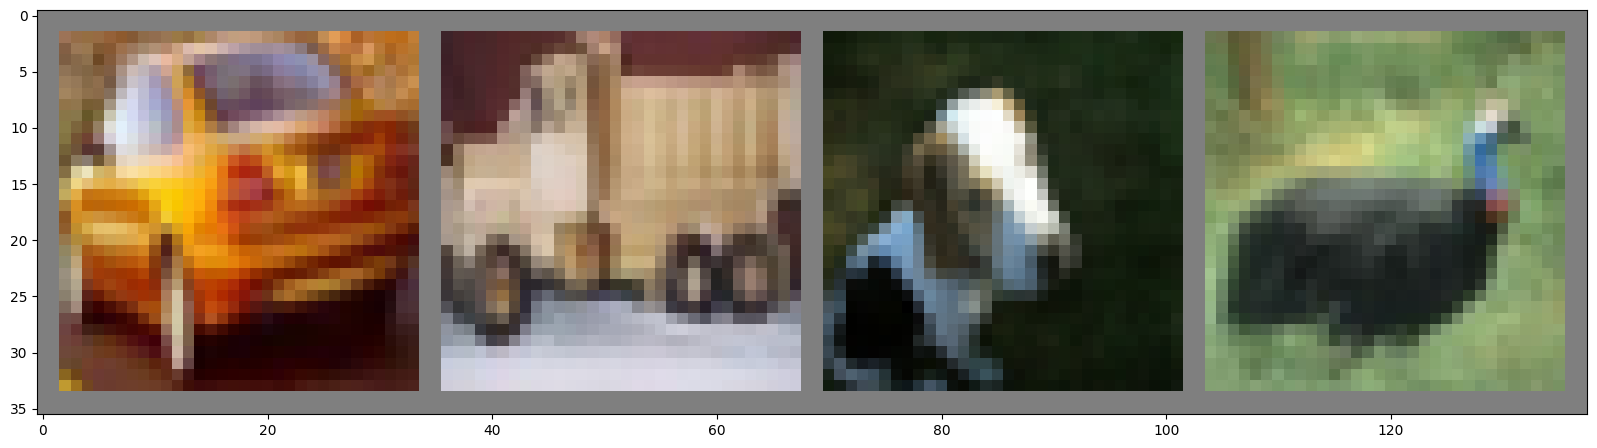

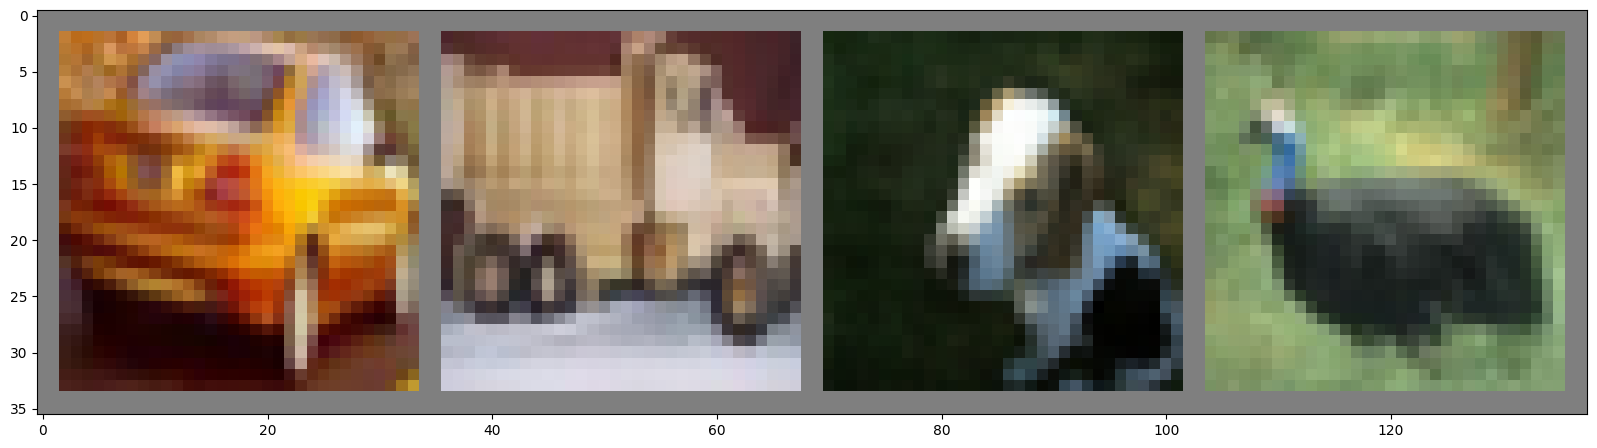

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4872424526232033, train acc: 0.4682439932875485
 val loss: 1.3111117342685132, val acc: 0.530629432708659

Epoch 1
 train loss: 1.191706573941372, train acc: 0.5810304583753485
 val loss: 1.1538716361877766, val acc: 0.6002216312479466

Epoch 2
 train loss: 1.0613411299925182, train acc: 0.6278972970066384
 val loss: 1.0372795267308013, val acc: 0.6408687944107867

Epoch 3
 train loss: 0.9970309241816157, train acc: 0.6539076782449725
 val loss: 1.0019493488555258, val acc: 0.6554964539852548

Epoch 4
 train loss: 0.959420253851296, train acc: 0.6667863672132683
 val loss: 1.0022111776027274, val acc: 0.6479831561129143

Epoch 5
 train loss: 0.925100010099533, train acc: 0.6796609754972092
 val loss: 0.9494871497154236, val acc: 0.6687943263256804

Epoch 6
 train loss: 0.9026752454816096, train acc: 0.6905074759200897
 val loss: 0.9778117760698846, val acc: 0.6613475178150421

Epoch 7
 train loss: 0.8952784258225283, train acc: 0.6878591016398051
 val loss: 0.892

Посчитайте точность на тестовой выборке:

In [ ]:
total = 0
correct = 0

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

  0%|          | 0/157 [00:00<?, ?it/s]

72.78 %


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

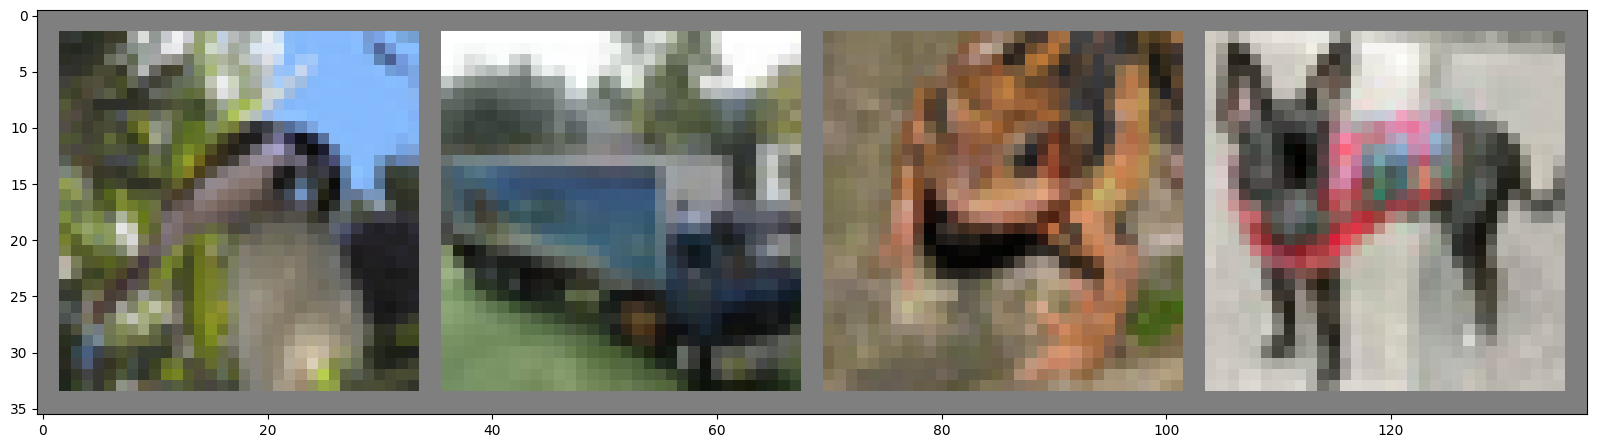

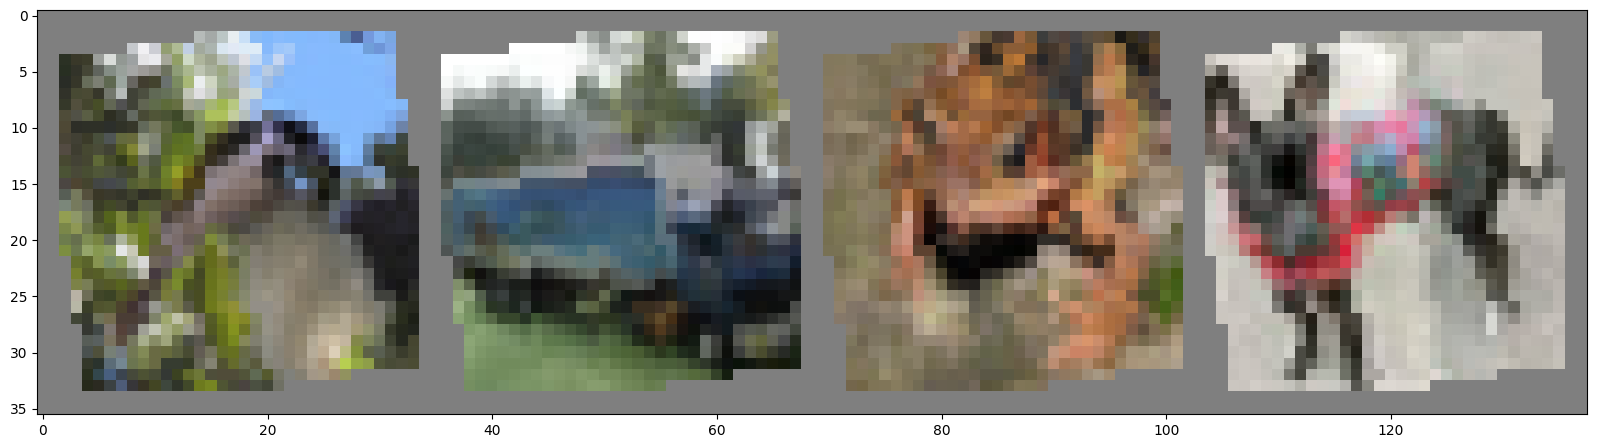

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.rotate(images[:4], angle=10)))

In [ ]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=10),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.523423491273981, train acc: 0.4548225712296732
 val loss: 1.3028246321576706, val acc: 0.5283466312479466

Epoch 1
 train loss: 1.236115571676704, train acc: 0.5662828088896366
 val loss: 1.1411525467608838, val acc: 0.595124113559723

Epoch 2
 train loss: 1.1202157603975187, train acc: 0.6087996213266139
 val loss: 1.0962436762261898, val acc: 0.620567376055616

Epoch 3
 train loss: 1.0533073247023867, train acc: 0.6323942282735975
 val loss: 1.0355235830266425, val acc: 0.6399822696726373

Epoch 4
 train loss: 1.0125158122950106, train acc: 0.6436447179731547
 val loss: 1.041496483062176, val acc: 0.6370567377577436

Epoch 5
 train loss: 0.9806158365017753, train acc: 0.6589351005484461
 val loss: 1.021780329562248, val acc: 0.6373891844394359

Epoch 6
 train loss: 0.9523614202600511, train acc: 0.6665129603807843
 val loss: 0.9600471174463313, val acc: 0.665913120736467

Epoch 7
 train loss: 0.9404650319646873, train acc: 0.6690389135855861
 val loss: 0.966396

In [ ]:
total = 0
correct = 0

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

  0%|          | 0/157 [00:00<?, ?it/s]

71.38 %


Ротации не помогают, видимо потому, что картинки шакальные
Попробуем помимо горизонтального отражения сделать ещё вертикальное.

In [ ]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.6498559057385656, train acc: 0.40099813929423556
 val loss: 1.4727081278537182, val acc: 0.46207890079376546

Epoch 1
 train loss: 1.392077284277684, train acc: 0.5028646514228319
 val loss: 1.3322589514103342, val acc: 0.5300088654173182

Epoch 2
 train loss: 1.2756798766430815, train acc: 0.5472218595867401
 val loss: 1.2790558284901559, val acc: 0.5484042553191489

Epoch 3
 train loss: 1.2140318316559033, train acc: 0.5689842321755028
 val loss: 1.2003618349420264, val acc: 0.5761746454746165

Epoch 4
 train loss: 1.1674632187081428, train acc: 0.5849071233320497
 val loss: 1.166856811401692, val acc: 0.5858599292471054

Epoch 5
 train loss: 1.1364310183298436, train acc: 0.5977776508226691
 val loss: 1.2043995900357023, val acc: 0.5713652482692232

Epoch 6
 train loss: 1.1033743362758015, train acc: 0.611521448252188
 val loss: 1.1339739713263004, val acc: 0.6014184398854032

Epoch 7
 train loss: 1.0939618855769282, train acc: 0.614373857404022
 val loss: 1.0

In [ ]:
total = 0
correct = 0

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)

    with torch.no_grad():
        logits = net(data)

    _, predicted = torch.max(logits.data, 1)
    predicted.to(device)
    correct += (predicted == target).sum().item()
    total += target.size(0)

print(round(correct / total * 100, 3), '%', sep=' ')

  0%|          | 0/157 [00:00<?, ?it/s]

66.15 %


Тоже не очень.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>